## Exercise 1.1: tidying a dataset.
Inspect the dataset contained in the le runtimes.csv and import it into Python as a pandas
dataframe. Note that one variable (the number of threads) is encoded in column names. Bring
this dataset into tidy form, as described in https://r4ds.hadley.nz/data-tidy.html using
functions such as pandas.melt (and some post-processing with auxiliary functions). Make sure
that columns in the resulting dataframe have meaningful names and dtypes.

In [161]:
## Importing necessary libraries
import pandas as pd

In [162]:
df = pd.read_csv('runtimes.csv', delimiter = '\t')

In [163]:
df.head

<bound method NDFrame.head of    # runtimes of two algorithms on problems of varying size, and with different number of threads
0             # algo: single or distributed algorithm                                            
1                                # size: problem size                                            
2   # time1 to time5: runtime in seconds for diffe...                                            
3             algo,size,time1,time2,time3,time4,time5                                            
4   distributed,4096,3.736606470743815,2.133074198...                                            
5   distributed,16384,14.792793687184652,7.8940310...                                            
6   distributed,65536,59.12334657775031,30.7624864...                                            
7   distributed,262144,240.7474482483334,124.44867...                                            
8   distributed,1048576,1097.7883522351583,567.038...                                   

In [164]:
df_1 = pd.read_csv('runtimes.csv', skiprows = 4) #skipped first 3 rows which contains the metadata and comments

In [165]:
df_1.head()

,algo,size,time1,time2,time3,time4,time5
0,distributed,4096,3.736606,2.133074,1.673441,1.515788,1.475265
1,distributed,16384,14.792794,7.894031,5.681171,4.597697,3.988286
2,distributed,65536,59.123347,30.762486,21.436608,16.510129,13.637740
3,distributed,262144,240.747448,124.448679,85.384094,64.732369,53.544233
4,distributed,1048576,1097.788352,567.038172,383.563617,290.182877,242.494498


In [166]:
#to bring the dataset into tidy form, we need to reshape 
#the dataset such that each variable forms a column and each observation forms a row
tidy_df = pd.melt(df_1, id_vars = ['algo','size'], 
                    value_vars = ['time1','time2','time3','time4','time5'], 
                    var_name = "time_type", 
                    value_name = "runtime")

In [167]:
tidy_df.head()

,algo,size,time_type,runtime
0,distributed,4096,time1,3.736606
1,distributed,16384,time1,14.792794
2,distributed,65536,time1,59.123347
3,distributed,262144,time1,240.747448
4,distributed,1048576,time1,1097.788352


In [168]:
#Inspecting columns dtypes

for column in tidy_df.columns:
    print(f'{column}: {tidy_df[column].dtype}')

algo: object
size: int64
time_type: object
runtime: float64


In [169]:
#further Processings
tidy_df.isnull().sum() #looking for null values

algo          0
size          0
time_type     0
runtime      16
dtype: int64

In [170]:
#we see "runtime" column has 16 null values. Now we need to figure out a way to deal with the null value. 
#Here, I will take into account  two options to deal with null value
#option 1: We can completely remove the rows which contains the null value
#option 2: Replace null values with the mean value of that particular column

In [171]:
null_values_by_algo = tidy_df.groupby('algo')['runtime'].apply(lambda x: x.isnull().sum()).reset_index()
null_values_by_algo.columns = ['algo', 'null_values']

In [172]:
null_values_by_algo

,algo,null_values
0,distributed,0
1,single,16


In [173]:
# Here we see all the null values belongs to "single" algorithm type, so it doesn't make sense to replace the null
#values with the mean of the whole dataset.
single_df = tidy_df[tidy_df['algo'] == 'single']

In [174]:
single_df_mean = single_df['runtime'].mean()
single_df_mean


110.0555408852441

In [175]:
#now we'll replace all the null values with mean runtime where algo is 'single'

tidy_df['runtime'].fillna(single_df_mean, inplace = True)

In [176]:
tidy_df.head()

,algo,size,time_type,runtime
0,distributed,4096,time1,3.736606
1,distributed,16384,time1,14.792794
2,distributed,65536,time1,59.123347
3,distributed,262144,time1,240.747448
4,distributed,1048576,time1,1097.788352


# Exercise 1.2: basic transformations and visualizations.
The file mpg-data.csv contains the mpg example dataset from the ggplot2 library (https:
//ggplot2.tidyverse.org/reference/mpg.html) which contains information about the fuel
efciency of various car models.

### 1. Import the dataset into Python via pandas and briey specify the dtype of each column(consult the documentation).


In [177]:
# importing data
MPG_df = pd.read_csv('mpg-data.csv')

In [178]:
MPG_df.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [179]:
# data types of each column
for column in MPG_df.columns:
    print(f'{column} : {MPG_df[column].dtype}')

manufacturer : object
model : object
displ : float64
year : int64
cyl : int64
trans : object
drv : object
cty : int64
hwy : int64
fl : object
class : object


### 2. Split the dataset into different car classes. For each class, perform a linear regression on the dependency of hwy on displ

In [180]:
#inspecting unique car classes

car_classes = MPG_df['class'].unique()
car_classes

array(['compact', 'midsize', 'suv', '2seater', 'minivan', 'pickup',
       'subcompact'], dtype=object)

In [181]:
#perform a linear regression on the dependency of hwy on displ
import statsmodels.api as sm
import matplotlib.pyplot as plt

def perform_regression(df):
    regression_results = {}
    
    for car_class in car_classes: 
        df_class = MPG_df[MPG_df['class'] == car_class]
        X = df_class['hwy'] #dependent variable
        y = df_class['displ'] #independent variable
        X = sm.add_constant(X)

        # Fit a linear regression model
        model = sm.OLS(y, X).fit()
        print(f'{car_class:}\n{model.params}\n')


In [182]:
perform_regression(car_classes)

compact
const    4.199243
hwy     -0.066214
dtype: float64

midsize
const    7.687410
hwy     -0.174606
dtype: float64

suv
const    8.694126
hwy     -0.233751
dtype: float64

2seater
const    7.40
hwy     -0.05
dtype: float64

minivan
const    4.475641
hwy     -0.048504
dtype: float64

pickup
const    8.255309
hwy     -0.227334
dtype: float64

subcompact
const    6.645268
hwy     -0.141608
dtype: float64



### 3. Give a scatter plot of hwy against displ. Make sure that the class of each car can be determined from the plot. Add straight lines showing the regression lines for each class. Make sure that your plot has appropriate axes labels and legends

### 4. Group the data by class and year and compute the median of hwy for each group. Present the resulting dataset as a table.

In [194]:
median_hwy_by_class = MPG_df.groupby(['class','year'])['hwy'].median().reset_index()

In [200]:
median_hwy_by_class.rename(columns = {'hwy':'median_hwy'}, inplace = True)

In [201]:
median_hwy_by_class

,class,year,median_hwy
0,2seater,1999,24.5
1,2seater,2008,25.0
2,compact,1999,26.0
3,compact,2008,29.0
4,midsize,1999,26.0
5,midsize,2008,28.0
6,minivan,1999,22.0
7,minivan,2008,23.0
8,pickup,1999,17.0
9,pickup,2008,17.0


# Exercise 1.3: hue rotation.
Import the photo of parrots used in the lecture (available at https://en.wikipedia.org/wik
i/File:BlueAndYellowMacaw_AraArarauna.jpg) in Python as shown in the lecture. Then for
a given angle φ ∈ [0, 2π), implement a function that converts the image to HSV space, applies a
rotation by angle φ to the hue channel (where φ = 2π would correspond to a whole rotation and
is thus equivalent to φ = 0), and transforms the resulting image back to RGB space. Apply this
function to the image for φ ∈ { k
2π
|k ∈ {0, 1, 2, 3, 4}} and visualize the obtained `rotated' images.

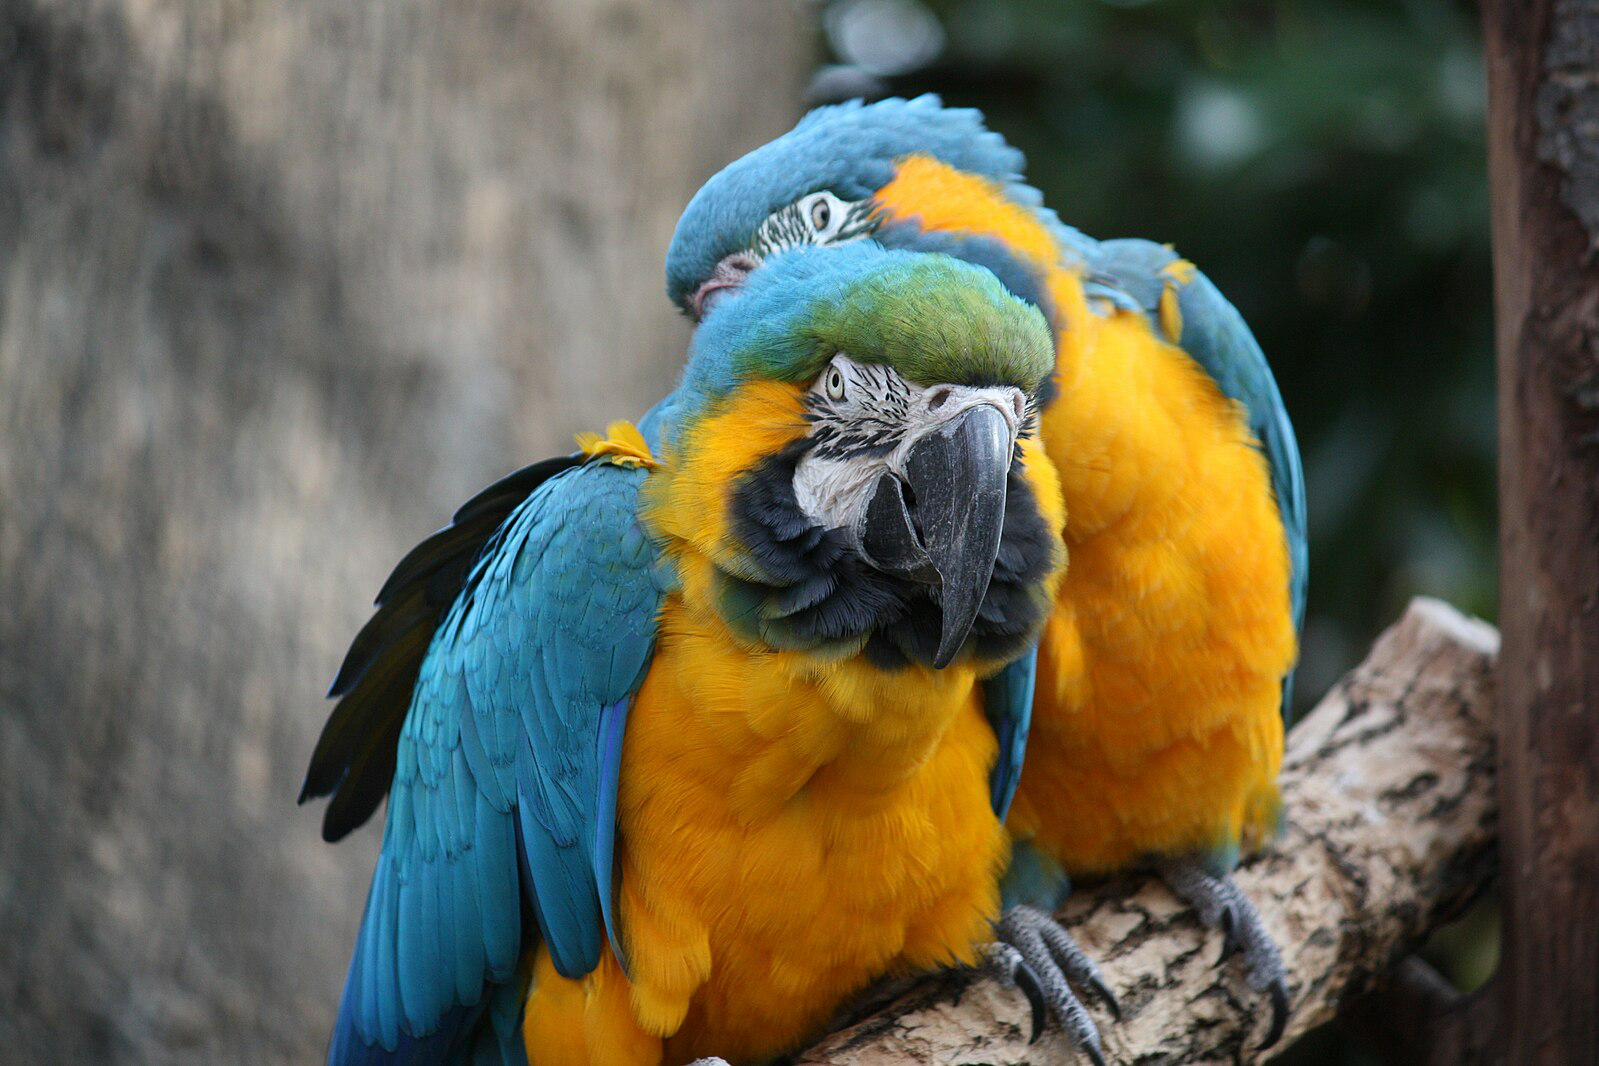

In [5]:
from PIL import Image

#loading the image
image_filename = "BlueAndYellowMacaw_AraArarauna.jpg"
image = Image.open(image_filename)
display(image)

In [18]:
import numpy as np

# Converting the image to HSV space
def rotate_hue(image):
    # Convert image to HSV
    image_hsv = image.convert("HSV")
   
    # Convert HSV image to NumPy array
    image_hsv_array = np.array(image_hsv)
    
    # Extract hue channel
    hue = image_hsv_array[:,:,0]

In [19]:
rotate_hue(image)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=HSV size=1599x1066 at 0x7FAF38AC7A90>

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=HSV size=1599x1066 at 0x7FAF38AC7A90>